# Fetching the data
We fetch the data and transform the image files using our transforms, in this case our images are already normalised, if they were RGB or nCh images we might want to normalise their respective channels as a pre-processing technique.

In [70]:
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from torchvision.datasets import MNIST
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

print(torch.__version__)
# #For some reason the download never completes, downlaoding manually

# train_dataset = MNIST(os.getcwd(), train=True, download=True, transform = None)
# test_dataset = MNIST(os.getcwd(), train=False, download=True, transform = None)

"""
Folks here (https://stackoverflow.com/questions/66577151/http-error-when-trying-to-download-mnist-data) \
describe that there seems to be issues sometimes with downlaoding the datasets when high traffic so I will just load them from \
here since i have tried a couple of tiems over the last few hours while runnig in background.
"""
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

train_set = MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=True)


test_set = MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=False)

1.10.1+cu102
--2022-01-12 17:10:04--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-01-12 17:10:04--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.2’

MNIST.tar.gz.2          [          <=>       ]  33.20M  18.3MB/s    in 1.8s    

2022-01-12 17:10:06 (18.3 MB/s) - ‘MNIST.tar.gz.2’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ub

# See what sort of data we have

This gives info about our train set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

This gives info about our test set

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

This gives info about our train samples class:index mapping

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}

This gives info about our test samples class:index mapping

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


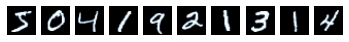

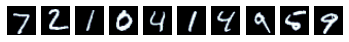

In [68]:
"""
We are checking here to make sure everything looks "normal" before proceeding. Such as we actually have datapoints to
train our model with and that the class:index mappings make sense e.g class "Number 5" is mapped to idx 5
of course it's fine if it wasnt, we would just have to udjust class lables to something sensible. Also checking that same classes
are used for train and test data.
"""

print("This gives info about our train set\n")
print(train_set)
print("\nThis gives info about our test set\n")
print(test_set)
print("\nThis gives info about our train samples class:index mapping\n")
print(train_set.class_to_idx)
print("\nThis gives info about our test samples class:index mapping\n")
print(test_set.class_to_idx)
#flipthatdict
idx2class = {v: k for k, v in train_set.class_to_idx.items()}

#see if we have images
N_IMAGES = 10

def plot_images(images):
    n_images = len(images)
    fig = plt.figure()
    for i in range(n_images):
        ax = fig.add_subplot(1, n_images, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')
        
train_images = [image for image, label in [train_set[i] for i in range(N_IMAGES)]]
test_images = [image for image, label in [test_set[i] for i in range(N_IMAGES)]]

plot_images(train_images)
plot_images(test_images)

# See that classes are distributed normally for our TRAIN dataset. 

seaborn imported
numpy imported
No Imbalance


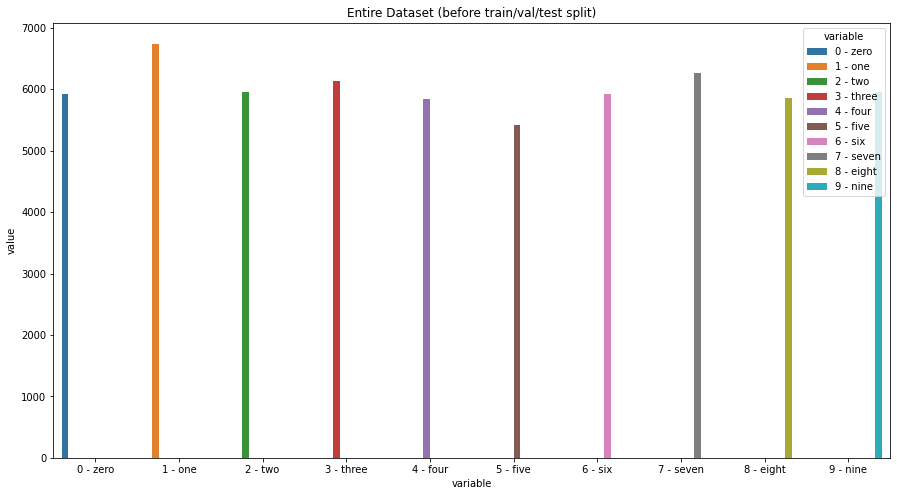

In [49]:
"""
We want to check that all the classes are distribued (relatively) evenly for a balanced training process
If we had significant data imbalance we could augment the minority classes to reduce class imbalance
"""
#checking if packages are installed, would contain all dependencies in a docker file if not just for quick example
try:
    import seaborn as sns
    print("seaborn imported")
    import numpy as np
    print("numpy imported")
except ImportError as e:
    !pip install seaborn
    !pip install numpy

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

#visual check
count_dic = get_class_distribution(train_set)
plt.figure(figsize=(15,8))
plot_from_dict(count_dic, plot_title="Entire Dataset (before train/val/test split)")

#mathmatical check to see if there is no major class imbalance
def ImbalanceCheck(count_dic):
        count_list = []
        for value in count_dic.values():
            count_list.append(value)
        mean = np.mean(count_list)
        std = np.std(count_list)
        pcdev = std/mean*100
        
        if pcdev > 10:
            print("Imbalance detected")
        else:
            print("No Imbalance")

ImbalanceCheck(count_dic)

In [139]:
#splitting our dataset

train_set_size = len(train_set)
train_set_indices = list(range(train_set_size))
np.random.shuffle(train_set_indices)
val_split_index = int(np.floor(0.2 * train_set_size))

#getting the list of indexes that correspond to our split and randomly subsampling                       
train_idx, val_idx = train_set_indices[val_split_index:], train_set_indices[:val_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
                         

In [140]:
train_loader = DataLoader(dataset=train_set, shuffle=False, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=train_set, shuffle=False, batch_size=1, sampler=val_sampler)
test_loader = DataLoader(dataset=test_set, shuffle=False, batch_size=1)


def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

#Could visualise class balances here but lets jsut check if they are fine using our previous function
#train distro
train_counts = get_class_distribution_loaders(train_loader, train_set)
#val distro
val_counts = get_class_distribution_loaders(val_loader, train_set)
ImbalanceCheck(train_counts)
ImbalanceCheck(val_counts)

No Imbalance
No Imbalance


In [208]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = ConvClassifier()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [209]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        #print(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            #print(train_losses)
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #Commented out since 
            torch.save(model.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [210]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [211]:
"""
After training for 10 epochs accuracy is 99% and test loss is higher than training loss so unlikely the model is overfitting.
Ideally I would implement an early stopping function where if test_loss > than train_loss then break from training loop.
Additionally, all aspects of the model training (code used to run, model artificats (settings,model,etc)) can be logged and
then optimised to a tracking server such as MLFlow 
(https://www.phdata.io/blog/bayesian-hyperparameter-optimization-with-mlflow/)
"""

n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
log_interval = 1000
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/tmp/ipykernel_3548/1051242959.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3063, Accuracy: 891/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.225564
Train Epoch: 1 [8000/60000 (17%)]	Loss: 0.841725
Train Epoch: 1 [16000/60000 (33%)]	Loss: 0.367243
Train Epoch: 1 [24000/60000 (50%)]	Loss: 0.520543
Train Epoch: 1 [32000/60000 (67%)]	Loss: 0.313352
Train Epoch: 1 [40000/60000 (83%)]	Loss: 0.676738

Test set: Avg. loss: 0.0980, Accuracy: 9701/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.214880
Train Epoch: 2 [8000/60000 (17%)]	Loss: 0.236312
Train Epoch: 2 [16000/60000 (33%)]	Loss: 0.107086
Train Epoch: 2 [24000/60000 (50%)]	Loss: 0.147480
Train Epoch: 2 [32000/60000 (67%)]	Loss: 0.131014
Train Epoch: 2 [40000/60000 (83%)]	Loss: 0.491564

Test set: Avg. loss: 0.0791, Accuracy: 9759/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.020525
Train Epoch: 3 [8000/60000 (17%)]	Loss: 0.021181
Train Epoch: 3 [16000/60000 (33%)]	Loss: 0.049216
Train Epoch: 3 [24000/60000 (50%)]	Loss: 0.004381
Train Epoch: 3 [32000/60000 (67%)]	Loss: 0.427

In [219]:
model.eval()
torch.save(model, 'results/shoop.pth')

